# Smoothed point frequency map of 1950-2013 tornado touchdown points.

Creation of smoothed density maps using numpy.histogram2d and scipy.ndimage.gaussian_filter

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import OA_tools

from scipy.ndimage import gaussian_filter as gfilt
from scipy.spatial import cKDTree
from mpl_toolkits import basemap
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
    

The method I use (gaussian filter) is sometimes used for image smoothing but the process can be done for grids.

I did a quick survey of the existing point density methods available to python users and many are complicated and do not scale well.

I had to abandon a few approaches before choosing this one because of how slow they are--but its easy to figure out why...

In [2]:
##example data.. can be any lat,lon data
torData = pd.read_csv('https://raw.githubusercontent.com/ahaberlie/hovmoller/master/torn_reports_minimal.csv',delimiter=',',header=0)
torData.head(4)

,Year,Month,Day,Date,Time,LAT,LON,FAT
0,1950,1,3,1/3/1950,11:00:00,38.77,-90.22,0
1,1950,1,3,1/3/1950,11:00:00,38.77,-90.22,0
2,1950,1,3,1/3/1950,11:10:00,38.82,-90.12,0
3,1950,1,3,1/3/1950,11:55:00,39.10,-89.30,0


59,000 points! That will put a damper on any nested iteration approaches.

In [3]:
torDat = torData[((torData.LON<-60) & (torData.LON>-130)) & ((torData.LAT>20) & (torData.LAT<60))]

lats = np.array(torDat['LAT'])
lons = np.array(torDat['LON'])

I like working with numpy arrays. Plus, these two lines strip the index column that comes with the DataFrame object

In [4]:
m = basemap.Basemap(
    width=4800000, height=3100000, projection='aea', resolution='l',
    lat_1=28.5, lat_2=44.5, lat_0=38.5, lon_0=-97.,area_thresh=5000)

This sets up a basemap object with a Lambert Conformal projection centered on the CONUS

In [5]:
x_proj, y_proj = m(lons, lats)
tor_points_proj = list(zip(x_proj, y_proj))

b_box = OA_tools.get_boundary_coords(x_proj, y_proj)

This projects the touchdown point lat/lons degrees into northing/easting meters.

This is important because a change in latitude is 111.2 km and a change in longitude varies with latitude. Thus, the spatial meaning of the point count per grid cell can become confusing if not in meters.

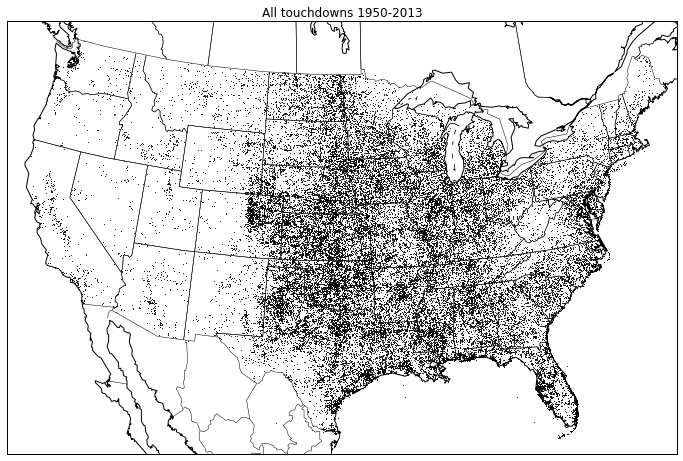

In [6]:
m.plot(x_proj,y_proj,'k.',markersize=1)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
plt.title("All touchdowns 1950-2013")

The following grid cell sizes and such should be used with caution. See:
http://journals.ametsoc.org/doi/pdf/10.1175/BAMS-D-11-00200.1

In [7]:
x_res = y_res = 10000
x_steps, y_steps = OA_tools.get_xy_steps(b_box, x_res, y_res)

print(x_steps, y_steps)
grid = OA_tools.smoothed_freq_map(x_proj, y_proj, b_box, x_steps, y_steps, 0)

457 285


Based on the number of x and y grids, this function will count up all of the points that fall within each range.  We do not care about spatial information at this point since the grid variable is more or less our "Z" value based on our segmented array we built above using linspace. If you were to plot this data as is...

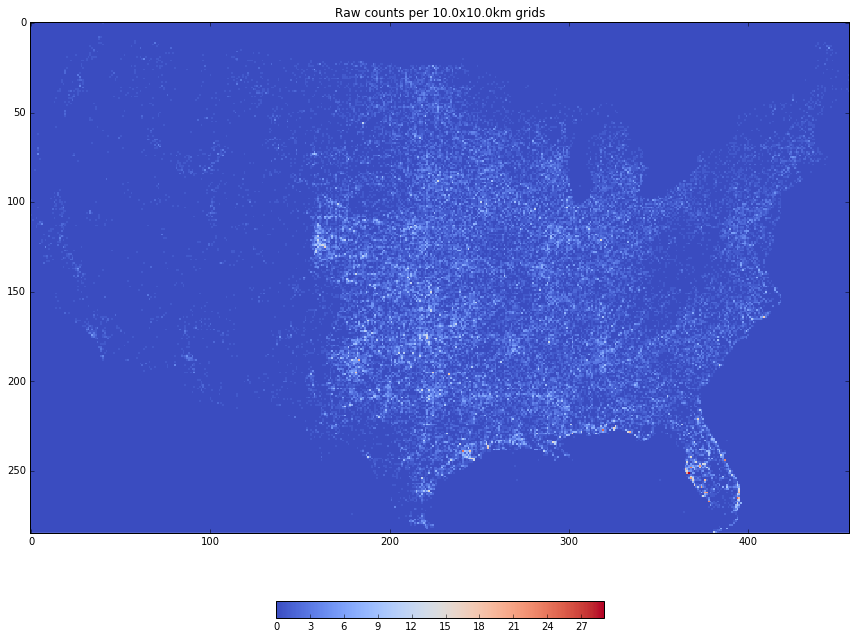

In [8]:
plt.title("Raw counts per " + str(x_res/1000) + "x" + str(y_res/1000) + "km grids")

plt.imshow(grid,cmap='coolwarm',interpolation='None')
plt.colorbar(shrink=.4,pad=.1,orientation='horizontal')
plt.tight_layout()

...you would see that it is a relatively small image-like object.  We need to use contourf to unite this image with its spatialness.

The data, even after they are aggregated to an xres by yres grid, are still a little noisy and this will make contourf hate you.

The answer (or one of the answers) is to use scipy.ndimage's gaussian_filter (that I have so descriptively called gfilt).

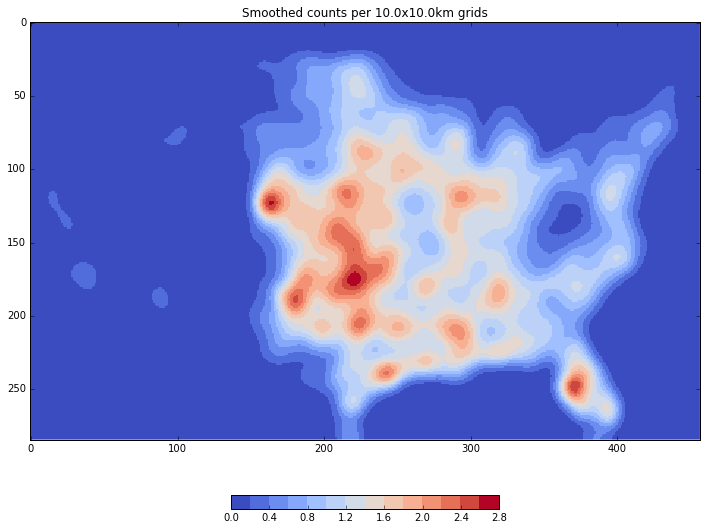

In [9]:
grid_smooth = gfilt(grid,sigma=6)

levels = MaxNLocator(nbins=15).tick_values(np.min(grid_smooth), np.max(grid_smooth))

cmap = plt.get_cmap('coolwarm')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.title("Smoothed counts per " + str(x_res/1000) + "x" + str(y_res/1000) + "km grids")
plt.imshow(grid_smooth,interpolation='None', cmap='coolwarm', norm=norm)
plt.colorbar(shrink=.4,pad=.1,orientation='horizontal')

The only problem with this, compared to point density, is that the choice of sigma and what it means spatially is kind of black boxed.  Typically, this is changed until things look good because it is usually used for pictures.  In our case, people really care about how things are spatially smoothed.

scipy's documentation lends some insight:

sigma : scalar or sequence of scalars
Standard deviation for Gaussian kernel. The standard deviations of the Gaussian filter are given for each axis as a sequence, or as a single number, in which case it is equal for all axes.

Basically, the larger the sigma this is how the spatial averaging will be changed:

1) Central grid cell counts less
2) Surrounding grids will count more

Lets try some cases:

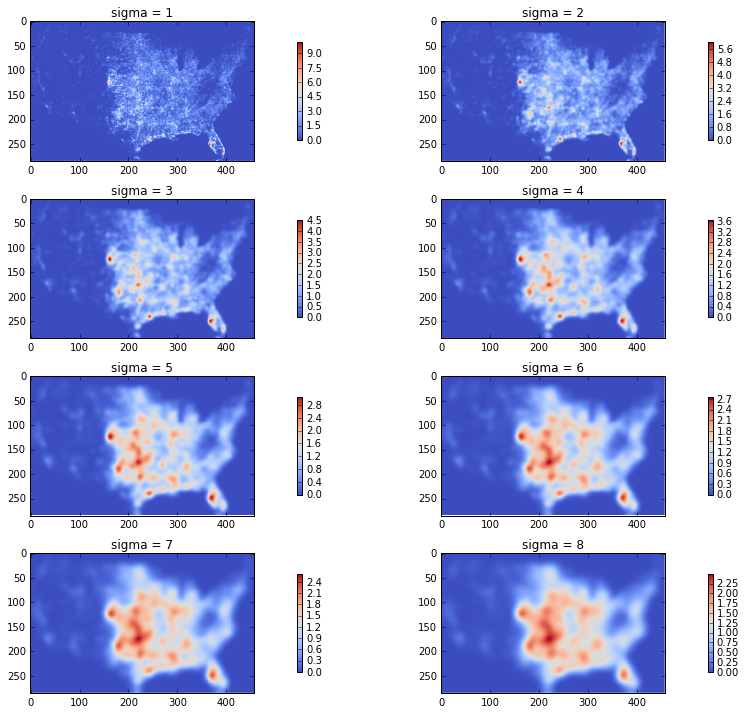

In [10]:
for i in range(1,9):
    sigma = i
    grid_sigma = gfilt(grid,sigma=sigma)

    plt.subplot(4,2,i)
    plt.title("sigma = " + str(sigma))
    plt.imshow(grid_sigma,interpolation='None', cmap='coolwarm')
    plt.colorbar(shrink=.7,pad=.1,orientation='vertical')
plt.tight_layout()

Mapping these images is done with pcolormesh or contourf using out linspace generated dimension segments

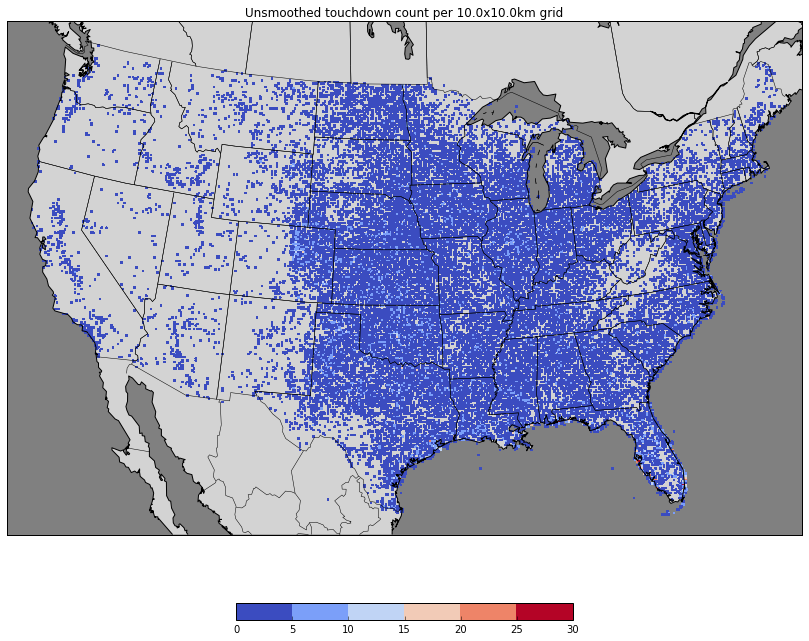

In [11]:
grid_ma = np.ma.masked_array(grid, grid==0)

levels = MaxNLocator(nbins=6).tick_values(np.min(grid_ma), np.max(grid_ma))

cmap = plt.get_cmap('coolwarm')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

gx, gy = OA_tools.generate_grid(x_res, y_res, b_box)
m.pcolormesh(gx, gy, grid_ma,cmap='coolwarm',norm=norm,zorder=2)
plt.colorbar(shrink=.4,pad=.1,orientation='horizontal')
#m.plot(x_proj,y_proj,'k.',markersize=1)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawmapboundary(fill_color='gray')
m.fillcontinents(color='lightgray',lake_color='gray')

plt.title("Unsmoothed touchdown count per " + str(x_res/1000) + "x" + str(y_res/1000) + "km grid")
plt.tight_layout()

Plot the smoothed version

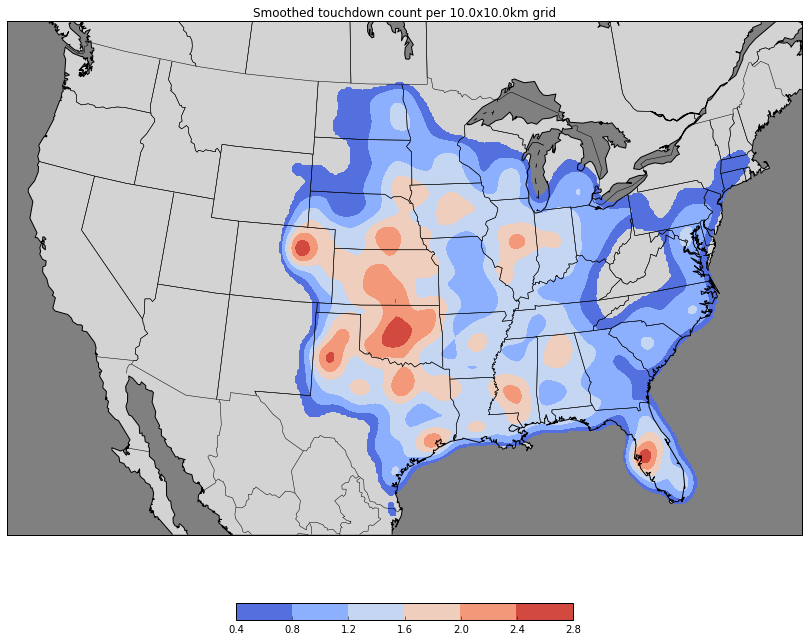

In [12]:
grid_s = np.ma.masked_where(grid_smooth < .5, grid_smooth)
plt.contourf(gx,gy,grid_s,cmap='coolwarm',zorder=2)
plt.colorbar(shrink=.4,pad=.1,orientation='horizontal')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawmapboundary(fill_color='gray')
m.fillcontinents(color='lightgray',lake_color='gray')
plt.title("Smoothed touchdown count per " + str(x_res/1000) + "x" + str(y_res/1000) + "km grid")

plt.tight_layout()

Now mask ocean grids

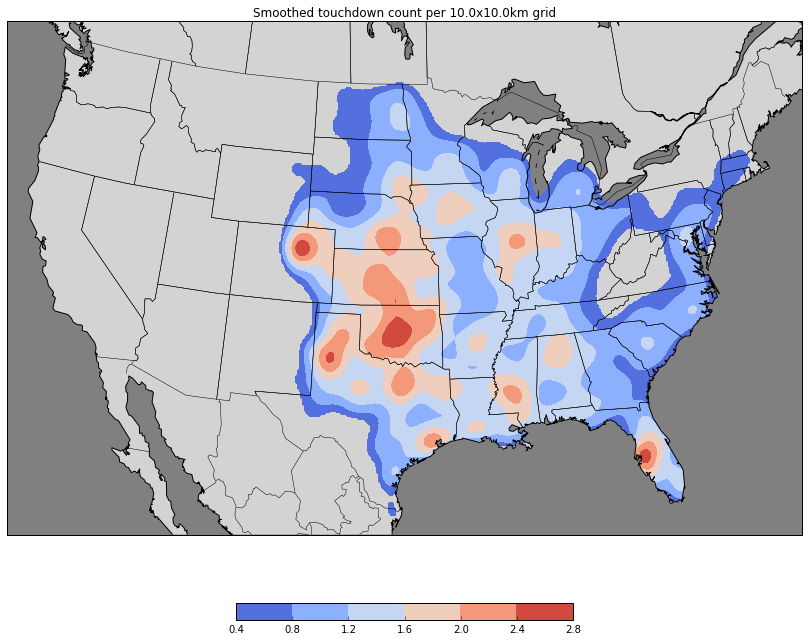

In [13]:
wgs84= basemap.pyproj.Proj("+init=EPSG:4326")
aea = basemap.pyproj.Proj(m.projparams)

lons_,lats_ = basemap.pyproj.transform(aea, wgs84, gx, gy)

grid_ = basemap.maskoceans(lons_, lats_, grid_s, inlands=False, resolution='l', grid=1.25)

plt.contourf(gx,gy,grid_,cmap='coolwarm',zorder=2)
plt.colorbar(shrink=.4,pad=.1,orientation='horizontal')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawmapboundary(fill_color='gray')
m.fillcontinents(color='lightgray',lake_color='gray')
plt.title("Smoothed touchdown count per " + str(x_res/1000) + "x" + str(y_res/1000) + "km grid")

plt.tight_layout()